In [18]:
import numpy as np
import sys, os 
sys.path.append('../Netket/')
sys.path.append('../ClusterExpansion/')
import netket as nk
import itertools
import matplotlib.pyplot as plt 
from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

In [19]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'
data_dirs_set = ['data_optimal_basis_rbm', 'extended_data_optimal_basis_rbm']
datadirs = [f'{data_root}/data/{data_dir_val}' for data_dir_val in data_dirs_set]
h5_files_opt = [f'{data_root}/data/{data_dir_val}/{fp}' for data_dir_val in datadirs for fp in os.listdir(data_dir_val) if fp.endswith('.h5')]

df_opt = analysis.load_outputs_to_dataframe_mult_thread(h5_files_opt, load_eigenstates=False, num_workers=8)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

KeyboardInterrupt: 

In [ ]:
features = list(hypotheses.keys())
traindf = df_opt[features + ['infidelity']].dropna()
traindf = traindf[traindf['infidelity'] <  0.6]
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['infidelity'], test_size=0.8, random_state=42)
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

Mean Squared Error: 0.026533446206458117
Percentage error in prediction: 969.3860479149819


In [ ]:
traindf.head()

,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,infidelity
0,0.179447,0.000042,0.978425,10.079338,0.761920,0.003465,0.000958
1,0.548042,0.000019,0.997826,10.877749,0.703497,0.003803,0.010293
2,0.571434,0.000234,0.955055,8.359235,0.475908,0.003180,0.077553
3,1.630023,0.000041,0.990663,10.113691,0.000204,0.003188,0.501937
4,0.409339,0.000042,0.980519,10.073536,0.705761,0.003542,0.006239


In [ ]:
features = list(hypotheses.keys())
traindf = df_opt[features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.05]
print(len(traindf))
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['Delta_E'], test_size=0.8, random_state=42)
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

646
Mean Squared Error: 7.592935315322686e-05
Percentage error in prediction: 169.07468305247556


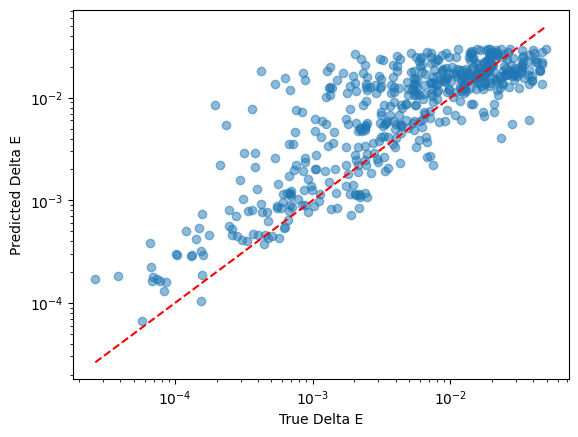

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

In [ ]:
xgbmodel = XGBRegressor(n_estimators=10000, 
                        random_state=42, 
                        learning_rate=0.01, 
                        early_stopping_rounds=10
                        )
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgbmodel.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGB Mean Squared Error: {mse_xgb}") 
print("XGB Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred_xgb) / y_test))

XGB Mean Squared Error: 7.998515862426643e-05
XGB Percentage error in prediction: 271.5928379504898


/tmp/ipykernel_3543703/3132712206.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=45, ha='right')
/tmp/ipykernel_3543703/3132712206.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=45, ha='right')


Text(0, 0.5, 'Feature Importance (RF)')

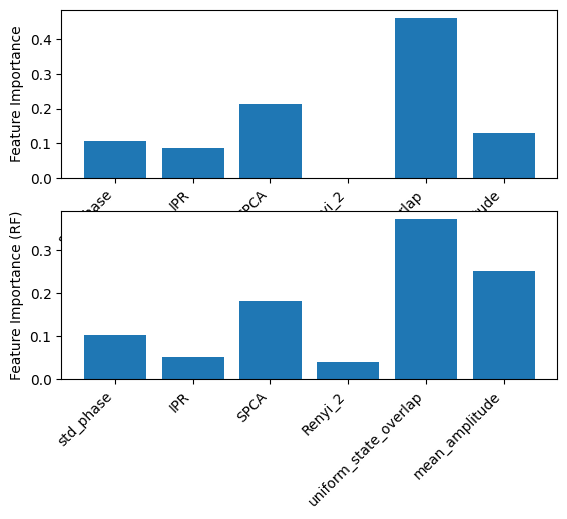

In [ ]:
fig, ax = plt.subplots(2)
ax[0].bar(features, xgbmodel.feature_importances_)
ax[0].set_xticklabels(features, rotation=45, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, model.feature_importances_)
ax[1].set_xticklabels(features, rotation=45, ha='right')
ax[1].set_ylabel('Feature Importance (RF)')

/tmp/ipykernel_3543703/3134863715.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=90, ha='right')
/tmp/ipykernel_3543703/3134863715.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=90, ha='right')


[Text(0, 0, 'std_phase'),
 Text(1, 0, 'IPR'),
 Text(2, 0, 'SPCA'),
 Text(3, 0, 'Renyi_2'),
 Text(4, 0, 'uniform_state_overlap'),
 Text(5, 0, 'mean_amplitude')]

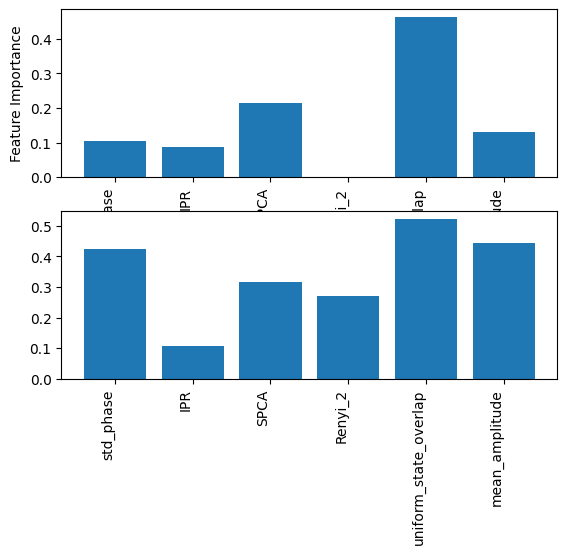

In [ ]:
fig, ax = plt.subplots(2)
scores = mutual_info_regression(X_train, y_train)

ax[0].bar(features, xgbmodel.feature_importances_)  # This does permutation importance i.e swap features and see drop in performance
ax[0].set_xticklabels(features, rotation=90, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, scores)
ax[1].set_xticklabels(features, rotation=90, ha='right')

In [ ]:
# Create a dataframe where each complex element of psi_0 is split into amplitude and phase
# Extract amplitude (magnitude) and phase for each element
psi_0_amp_phase = []

for psi_vector in df_opt['psi_0']:
    psi_complex = np.asarray(psi_vector)
    amp = np.abs(psi_complex)
    phase = np.angle(psi_complex)
    psi_0_amp_phase.append(np.concatenate([amp, phase]))

# Create dataframe with amplitude and phase columns
psi_0_expanded = pd.DataFrame(psi_0_amp_phase)
n_elements = len(np.asarray(df_opt['psi_0'].iloc[0]))
amp_cols = [f'psi_0_{i}_amp' for i in range(n_elements)]
phase_cols = [f'psi_0_{i}_phase' for i in range(n_elements)]
psi_0_expanded.columns = amp_cols + phase_cols

# Combine with Delta_E target
df_psi = pd.concat([psi_0_expanded, df_opt[['Delta_E']].reset_index(drop=True)], axis=1)

# Remove rows with NaN values
df_psi = df_psi.dropna()

print(f"DataFrame shape: {df_psi.shape}")
print(f"Total features (amplitude + phase): {len(amp_cols + phase_cols)}")
print(f"Columns: {psi_0_expanded.columns.tolist()[:10]}... (showing first 10)")
print(f"\nTarget (Delta_E) statistics:")
print(df_psi['Delta_E'].describe())

KeyboardInterrupt: 

In [ ]:
# Split into train/test and train random forest
X_psi = df_psi.drop('Delta_E', axis=1)
y_psi = df_psi['Delta_E']

X_train_psi, X_test_psi, y_train_psi, y_test_psi = train_test_split(
    X_psi, y_psi, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train_psi.shape[0]}")
print(f"Test set size: {X_test_psi.shape[0]}")
print(f"Number of features (psi_0 elements): {X_train_psi.shape[1]}")

# Train random forest model
rf_model_psi = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
rf_model_psi.fit(X_train_psi, y_train_psi)

# Evaluate
y_pred_psi = rf_model_psi.predict(X_test_psi)
mse_psi = mean_squared_error(y_test_psi, y_pred_psi)

print(f"\nRandom Forest (psi_0 elements as features)")
print(f"Mean Squared Error: {mse_psi}")
print(f"R² Score (Test): {rf_model_psi.score(X_test_psi, y_test_psi):.4f}")
print(f"RMSE: {np.sqrt(mse_psi):.6f}")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test_psi - y_pred_psi)):.6f}")

Training set size: 560
Test set size: 140
Number of features (psi_0 elements): 65536


ValueError: Complex data not supported
                                            psi_0_0             psi_0_1  \
82   4.683910e-03+1.006668e-                    02j  0.000865+0.006342j   
51  -8.385772e-04-6.076609e-                    04j -0.000927-0.000465j   
220 -2.083470e-14+5.751112e-                    15j -0.000899+0.000093j   
669 -8.783846e-04+3.282808e-                    03j -0.000668+0.000986j   
545 -1.872986e-15+2.287745e-                    15j  0.000764+0.000822j   
..                                              ...                 ...   
71   2.435308e-03+1.011439e-                    02j  0.005867+0.005909j   
106 -5.240337e-03+5.086967e-                    03j -0.001575+0.004340j   
270 -4.602484e-03+8.496894e-                    03j -0.002294+0.007086j   
435  2.960810e-05+7.088529e-                    04j -0.000482+0.000539j   
102 -4.183698e-05-4.862717e-                    05j -0.000116-0.000095j   

                psi_0_2             psi_0_3             psi_0_4  \
82   0.000865+0.006342j -0.004729+0.001836j  0.000865+0.006342j   
51  -0.000927-0.000465j -0.000662-0.000153j -0.000927-0.000465j   
220  0.000899-0.000093j -0.000306+0.000043j -0.000899+0.000093j   
669 -0.000668+0.000986j -0.000253+0.000169j -0.000668+0.000986j   
545  0.000764+0.000822j -0.001357+0.000913j  0.000764+0.000822j   
..                  ...                 ...                 ...   
71   0.005867+0.005909j  0.005587+0.004917j  0.005867+0.005909j   
106 -0.001575+0.004340j  0.000881+0.002396j -0.001575+0.004340j   
270 -0.002294+0.007086j -0.001504+0.005444j -0.002294+0.007086j   
435 -0.000482+0.000539j -0.000569+0.000866j -0.000482+0.000539j   
102 -0.000116-0.000095j -0.000145-0.000199j -0.000116-0.000095j   

                psi_0_5             psi_0_6             psi_0_7  \
82  -0.003482+0.003253j -0.004729+0.001836j -0.003862-0.002856j   
51  -0.000904-0.000356j -0.000662-0.000153j -0.000448+0.000023j   
220 -0.000865-0.001751j  0.000306-0.000043j -0.000945+0.000278j   
669 -0.000424-0.000655j -0.000253+0.000169j  0.000006-0.000479j   
545 -0.001474-0.000090j -0.001357+0.000913j -0.001006-0.004628j   
..                  ...                 ...                 ...   
71   0.006456+0.002038j  0.005587+0.004917j  0.006455+0.003830j   
106  0.001028+0.002693j  0.000881+0.002396j  0.001370+0.000864j   
270 -0.000682+0.005546j -0.001504+0.005444j -0.000912+0.004261j   
435 -0.001415+0.001397j -0.000569+0.000866j  0.000474+0.001157j   
102 -0.000340-0.000239j -0.000145-0.000199j -0.000130-0.000419j   

                psi_0_8             psi_0_9  ...         psi_0_65526  \
82   0.000865+0.006342j -0.004729+0.001836j  ...  0.000063+0.004141j   
51  -0.000927-0.000465j -0.000662-0.000153j  ... -0.000348+0.000156j   
220  0.000899-0.000093j  0.000306-0.000043j  ...  0.000394-0.000170j   
669 -0.000668+0.000986j -0.000253+0.000169j  ... -0.000609+0.000135j   
545  0.000764+0.000822j -0.001357+0.000913j  ... -0.004625-0.007239j   
..                  ...                 ...  ...                 ...   
71   0.005867+0.005909j  0.005587+0.004917j  ...  0.004587+0.005224j   
106 -0.001575+0.004340j  0.000881+0.002396j  ...  0.002065+0.000724j   
270 -0.002294+0.007086j -0.001504+0.005444j  ... -0.001059+0.006029j   
435 -0.000482+0.000539j -0.000569+0.000866j  ...  0.000302+0.000291j   
102 -0.000116-0.000095j -0.000145-0.000199j  ... -0.000336+0.000038j   

            psi_0_65527         psi_0_65528         psi_0_65529  \
82   0.001910+0.003294j -0.003766+0.002597j  0.000063+0.004141j   
51  -0.000375+0.000179j -0.000133+0.000281j -0.000348+0.000156j   
220 -0.001074+0.000470j  0.001213-0.000252j  0.000394-0.000170j   
669 -0.000599+0.000985j -0.000049-0.000430j -0.000609+0.000135j   
545 -0.004911-0.002096j  0.004919-0.009980j -0.004625-0.007239j   
..                  ...                 ...                 ...   
71   0.003816+0.007737j  0.006394+0.003733j  0.004587+0.005224j   
106 -0.001910+0.005471j  0.001268-0.001152j  0.002065+0.000724j   
270 -0.001662+0.007813j -0.000520+0.004650j -0.001059+0.006029j   
435 -0.000654+0.000304j  0.000864+0.000676j  0.000302+0.000291j   
102 -0.000231+0.000139j -0.000428-0.000147j -0.000336+0.000038j   

            psi_0_65530         psi_0_65531         psi_0_65532  \
82   0.001436+0.005934j  0.001910+0.003294j  0.000063+0.004141j   
51  -0.000865+0.000189j -0.000375+0.000179j -0.000348+0.000156j   
220  0.000919+0.002410j  0.001074-0.000470j -0.000394+0.000170j   
669 -0.000347-0.000418j -0.000599+0.000985j -0.000609+0.000135j   
545 -0.003772-0.004053j -0.004911-0.002096j -0.004625-0.007239j   
..                  ...                 ...                 ...   
71   0.006861+0.002281j  0.003816+0.007737j  0.004587+0.005224j   
106  0.002137+0.000631j -0.001910+0.005471j  0.002065+0.000724j   
270 -0.000438+0.005930j -0.001662+0.007813j -0.001059+0.006029j   
435 -0.000150+0.000475j -0.000654+0.000304j  0.000302+0.000291j   
102 -0.000501+0.000146j -0.000231+0.000139j -0.000336+0.000038j   

            psi_0_65533         psi_0_65534  \
82   0.001910+0.003294j  0.001910+0.003294j   
51  -0.000375+0.000179j -0.000375+0.000179j   
220 -0.001074+0.000470j  0.001074-0.000470j   
669 -0.000599+0.000985j -0.000599+0.000985j   
545 -0.004911-0.002096j -0.004911-0.002096j   
..                  ...                 ...   
71   0.003816+0.007737j  0.003816+0.007737j   
106 -0.001910+0.005471j -0.001910+0.005471j   
270 -0.001662+0.007813j -0.001662+0.007813j   
435 -0.000654+0.000304j -0.000654+0.000304j   
102 -0.000231+0.000139j -0.000231+0.000139j   

                                        psi_0_65535  
82   7.304270e-04+3.405547e-                    03j  
51  -2.555023e-04+1.517523e-                    04j  
220 -2.067283e-14+2.030106e-                    14j  
669 -2.313911e-04+3.168559e-                    03j  
545 -2.467150e-14+1.175791e-                    14j  
..                                              ...  
71  -2.386588e-03+9.117414e-                    03j  
106 -7.886461e-03+8.587771e-                    03j  
270 -3.492694e-03+1.049164e-                    02j  
435 -5.318536e-04+4.670553e-                    04j  
102 -1.028273e-04+1.031167e-                    04j  

[560 rows x 65536 columns]


In [ ]:
# Visualize predictions vs actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1.scatter(y_test_psi, y_pred_psi, alpha=0.5)
ax1.set_xlabel('True Delta E')
ax1.set_ylabel('Predicted Delta E')
ax1.set_title('Predictions vs Actual (psi_0 features)')
ax1.plot([y_test_psi.min(), y_test_psi.max()], [y_test_psi.min(), y_test_psi.max()], 'r--', lw=2)
ax1.grid(True, alpha=0.3)

# Residuals
residuals = y_test_psi - y_pred_psi
ax2.scatter(y_pred_psi, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Delta E')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual mean: {residuals.mean():.6f}")
print(f"Residual std: {residuals.std():.6f}")